In [1]:
! pip install statsmodels ipywidgets dask dask-ml > /dev/null


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import scipy
from scipy import stats as stats
import math
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import glob
import dask.dataframe as dd
from dask_ml.linear_model import LinearRegression
import dask


/root/venv/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
# Directory containing your Parquet files
parquet_files_dir = '/work/data/session-by-vin-v16'

# List all Parquet files in the directory
parquet_files = [
    os.path.join(parquet_files_dir, f) 
    for f in os.listdir(parquet_files_dir) 
    if f.endswith('.parquet')
]

# Function to read a Parquet file and add a filename column
def read_parquet_with_filename(filepath):
    # Read the Parquet file
    df: dd.DataFrame = dd.read_parquet(filepath)
    # Add a column with the filename
    df['source_file'] = str(os.path.basename(filepath))

    # At the dataset; each vehicle seems to have changed their battery at the last year 
    half_idx = df.shape[0].compute() // 2
    print(f'{ half_idx = }')
    idx_new_battery = df.loc[half_idx:]['full_capacity'].idxmax().compute()
    df = df.loc[idx_new_battery:]
    return df

ddf_list = [
    read_parquet_with_filename(f) for f in parquet_files
]



 half_idx = 810
 half_idx = 692
 half_idx = 777
 half_idx = 789
 half_idx = 769
 half_idx = 776
 half_idx = 659
 half_idx = 800
 half_idx = 731
 half_idx = 821
 half_idx = 771
 half_idx = 825
 half_idx = 785
 half_idx = 772
 half_idx = 812
 half_idx = 805
 half_idx = 785
 half_idx = 795
 half_idx = 785
 half_idx = 754


In [4]:
ddf_list[0].head()

,start_soc,end_soc,start_capacity,end_capacity,start_time,end_time,source_file,charging_type,diff_soc,diff_capacity,duration,full_capacity
new_session,,,,,,,,,,,,
100000276,6.400000,10.800000,8.770000,14.890000,2019-12-13 15:17:57,2019-12-13 15:28:15,1.parquet,DC,4.400000,6.120000,0 days 00:10:18,137.870377
100000277,11.200000,77.599998,15.120000,105.660004,2019-12-13 15:54:01,2019-12-13 18:29:59,1.parquet,DC,66.400002,90.540001,0 days 02:35:58,136.159805
100000278,15.600000,68.000000,21.040001,92.660004,2019-12-14 01:30:33,2019-12-14 03:13:50,1.parquet,DC,52.400002,71.620003,0 days 01:43:17,136.264709
100000279,68.000000,76.800003,92.709999,104.470001,2019-12-14 04:54:20,2019-12-14 05:04:28,1.parquet,DC,8.800003,11.760002,0 days 00:10:08,136.028641
100000280,76.800003,76.400002,104.290001,104.260002,2019-12-14 07:05:51,2019-12-14 07:08:31,1.parquet,DC,-0.400002,-0.029999,0 days 00:02:40,136.465973


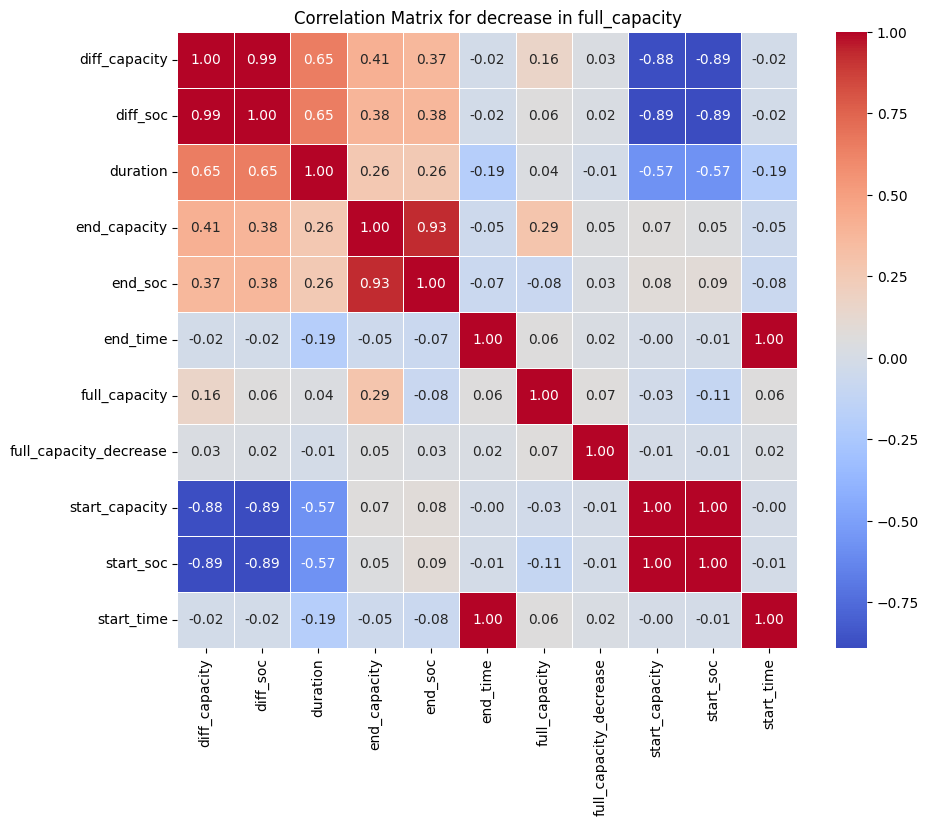

In [5]:
import os
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

test_ddf = ddf_list[0]
test_df = test_ddf.compute()
test_df['full_capacity_decrease'] = test_df['full_capacity'].diff().fillna(0)
test_df = test_df[test_df['full_capacity_decrease'] != 0]

columns_for_correlation = test_df.columns.difference(['source_file', 'record_time', 'new_session', 'charging_type'])
correlation_matrix = test_df[columns_for_correlation].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix for decrease in full_capacity')
plt.show()

In [6]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

def get_df_sessions_for_vin(vin):
    df_sessions = ddf_list[0].compute().copy()
    import pandas as pd
    import numpy as np
    import statsmodels.formula.api as smf

    # Assuming df_sessions is your DataFrame
    df_sessions['end_time'] = pd.to_datetime(df_sessions['end_time'])
    df_sessions = df_sessions.sort_values(by='end_time')

    # Convert charging_type to integer columns
    df_sessions['charging_type_DC'] = df_sessions['charging_type'].apply(lambda x: 1 if x == 'DC' else 0)
    df_sessions['charging_type_AC'] = df_sessions['charging_type'].apply(lambda x: 1 if x == 'AC' else 0)

    # Apply rolling window
    window_size = 5  # Adjust the window size as needed
    df_sessions['rolling_diff_soc'] = df_sessions['diff_soc'].rolling(window=window_size, min_periods=1).sum()
    df_sessions['rolling_charging_type_DC'] = df_sessions['charging_type_DC'].rolling(window=window_size, min_periods=1).sum()
    df_sessions['rolling_charging_type_AC'] = df_sessions['charging_type_AC'].rolling(window=window_size, min_periods=1).sum()

    # Create rolling interaction terms
    df_sessions['rolling_diff_soc_DC'] = (df_sessions['diff_soc'] * df_sessions['charging_type_DC']).rolling(window=window_size, min_periods=1).sum()
    df_sessions['rolling_diff_soc_AC'] = (df_sessions['diff_soc'] * df_sessions['charging_type_AC']).rolling(window=window_size, min_periods=1).sum()

    # Apply rolling window to end_capacity for degraded_capacity

    def get_change(rows):
        return rows.iloc[-1] - rows.iloc[0]

    df_sessions['rolling_degraded_capacity'] = df_sessions['full_capacity'].rolling(window=window_size, min_periods=1).agg(get_change)

    # Drop NaN values resulting from rolling calculations
    df_sessions = df_sessions.dropna()
    return df_sessions

df_sessions = pd.concat([get_df_sessions_for_vin(vin) for vin in range(20)])



In [7]:
print(ddf_list[0].head())

             start_soc    end_soc  start_capacity  end_capacity  \
new_session                                                       
100000276     6.400000  10.800000        8.770000     14.890000   
100000277    11.200000  77.599998       15.120000    105.660004   
100000278    15.600000  68.000000       21.040001     92.660004   
100000279    68.000000  76.800003       92.709999    104.470001   
100000280    76.800003  76.400002      104.290001    104.260002   

                     start_time            end_time source_file charging_type  \
new_session                                                                     
100000276   2019-12-13 15:17:57 2019-12-13 15:28:15   1.parquet            DC   
100000277   2019-12-13 15:54:01 2019-12-13 18:29:59   1.parquet            DC   
100000278   2019-12-14 01:30:33 2019-12-14 03:13:50   1.parquet            DC   
100000279   2019-12-14 04:54:20 2019-12-14 05:04:28   1.parquet            DC   
100000280   2019-12-14 07:05:51 2019-12-14 0

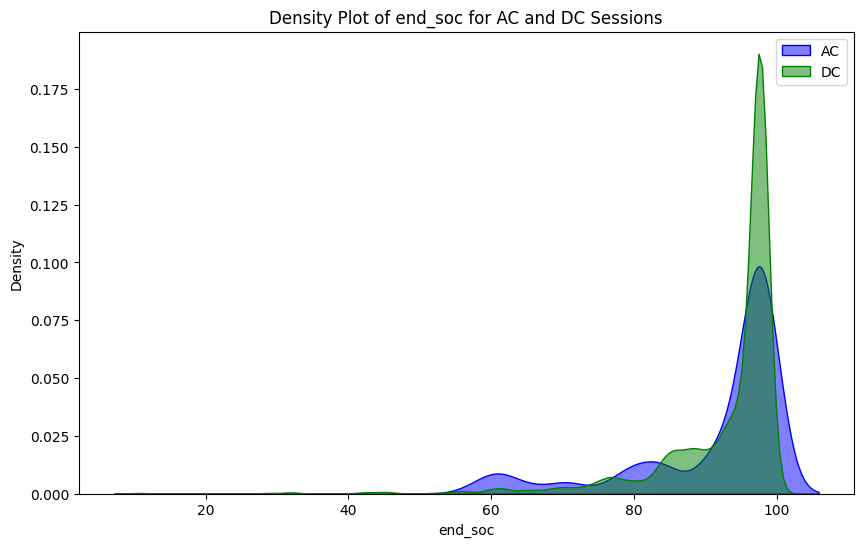

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_sessions is your DataFrame
df_sessions['end_time'] = pd.to_datetime(df_sessions['end_time'])
df_sessions = df_sessions.sort_values(by='end_time')

# Filter the data for AC and DC sessions
ac_sessions = df_sessions[df_sessions['charging_type'] == 'AC']
dc_sessions = df_sessions[df_sessions['charging_type'] == 'DC']

# Plotting the overlaid density plots
plt.figure(figsize=(10, 6))

sns.kdeplot(ac_sessions['end_soc'], color='blue', fill=True, alpha=0.5, label='AC')
sns.kdeplot(dc_sessions['end_soc'], color='green', fill=True, alpha=0.5, label='DC')

plt.xlabel('end_soc')
plt.ylabel('Density')
plt.title('Density Plot of end_soc for AC and DC Sessions')
plt.legend()

plt.show()


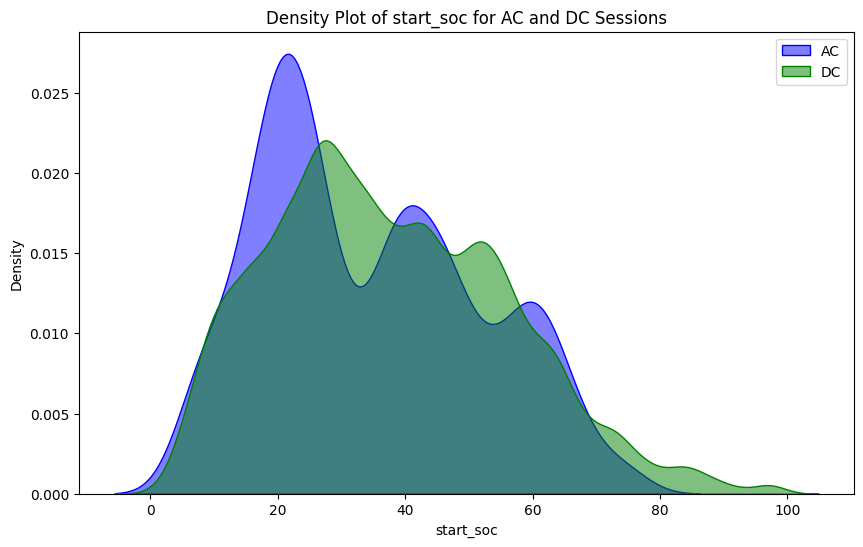

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_sessions is your DataFrame
df_sessions['end_time'] = pd.to_datetime(df_sessions['end_time'])
df_sessions = df_sessions.sort_values(by='end_time')

# Filter the data for AC and DC sessions
ac_sessions = df_sessions[df_sessions['charging_type'] == 'AC']
dc_sessions = df_sessions[df_sessions['charging_type'] == 'DC']

# Plotting the overlaid density plots
plt.figure(figsize=(10, 6))

sns.kdeplot(ac_sessions['start_soc'], color='blue', fill=True, alpha=0.5, label='AC')
sns.kdeplot(dc_sessions['start_soc'], color='green', fill=True, alpha=0.5, label='DC')

plt.xlabel('start_soc')
plt.ylabel('Density')
plt.title('Density Plot of start_soc for AC and DC Sessions')
plt.legend()

plt.show()

In [10]:
df_sessions

,start_soc,end_soc,start_capacity,end_capacity,start_time,end_time,source_file,charging_type,diff_soc,diff_capacity,duration,full_capacity,charging_type_DC,charging_type_AC,rolling_diff_soc,rolling_charging_type_DC,rolling_charging_type_AC,rolling_diff_soc_DC,rolling_diff_soc_AC,rolling_degraded_capacity
new_session,,,,,,,,,,,,,,,,,,,,
100000276,6.4,10.800000,8.77,14.890000,2019-12-13 15:17:57,2019-12-13 15:28:15,1.parquet,DC,4.400000,6.120000,0 days 00:10:18,137.870377,1,0,4.400000,1.0,0.0,4.400000,0.0,0.000000
100000276,6.4,10.800000,8.77,14.890000,2019-12-13 15:17:57,2019-12-13 15:28:15,1.parquet,DC,4.400000,6.120000,0 days 00:10:18,137.870377,1,0,4.400000,1.0,0.0,4.400000,0.0,0.000000
100000276,6.4,10.800000,8.77,14.890000,2019-12-13 15:17:57,2019-12-13 15:28:15,1.parquet,DC,4.400000,6.120000,0 days 00:10:18,137.870377,1,0,4.400000,1.0,0.0,4.400000,0.0,0.000000
100000276,6.4,10.800000,8.77,14.890000,2019-12-13 15:17:57,2019-12-13 15:28:15,1.parquet,DC,4.400000,6.120000,0 days 00:10:18,137.870377,1,0,4.400000,1.0,0.0,4.400000,0.0,0.000000
100000276,6.4,10.800000,8.77,14.890000,2019-12-13 15:17:57,2019-12-13 15:28:15,1.parquet,DC,4.400000,6.120000,0 days 00:10:18,137.870377,1,0,4.400000,1.0,0.0,4.400000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100001619,25.6,95.200005,33.48,124.189995,2021-11-15 15:36:32,2021-11-15 16:46:40,1.parquet,DC,69.600006,90.709991,0 days 01:10:08,130.451675,1,0,305.599995,5.0,0.0,305.599995,0.0,-0.388489
100001619,25.6,95.200005,33.48,124.189995,2021-11-15 15:36:32,2021-11-15 16:46:40,1.parquet,DC,69.600006,90.709991,0 days 01:10:08,130.451675,1,0,305.599995,5.0,0.0,305.599995,0.0,-0.388489
100001619,25.6,95.200005,33.48,124.189995,2021-11-15 15:36:32,2021-11-15 16:46:40,1.parquet,DC,69.600006,90.709991,0 days 01:10:08,130.451675,1,0,305.599995,5.0,0.0,305.599995,0.0,-0.388489


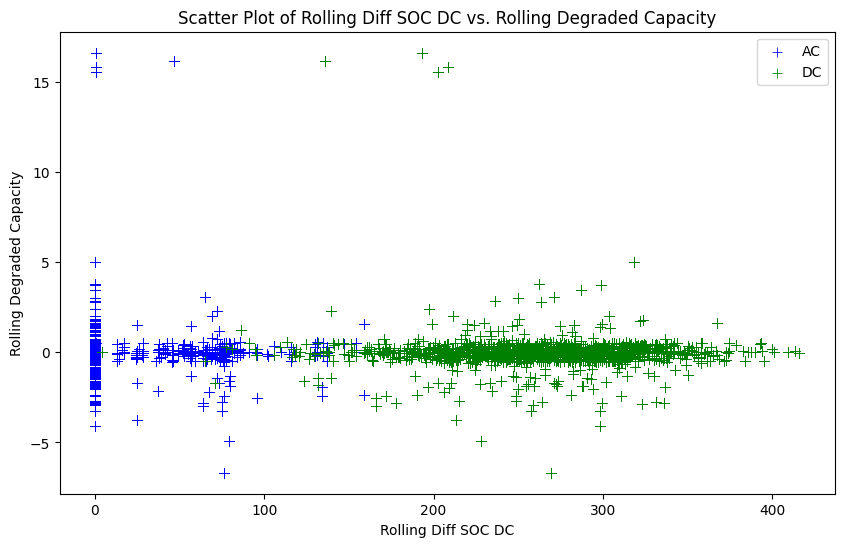

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_sessions is your DataFrame
df_sessions['end_time'] = pd.to_datetime(df_sessions['end_time'])
df_sessions = df_sessions.sort_values(by='end_time')

# Create scatter plots
plt.figure(figsize=(10, 6))

# Scatter plot for AC sessions
sns.scatterplot(data=df_sessions, y='rolling_degraded_capacity', x='rolling_diff_soc_AC', color='blue', label='AC', marker="+", s=50)

# Scatter plot for DC sessions
sns.scatterplot(data=df_sessions, y='rolling_degraded_capacity', x='rolling_diff_soc_DC', color='green', label='DC', marker="+", s=50)

# Set axis labels and title
plt.ylabel('Rolling Degraded Capacity')
plt.xlabel('Rolling Diff SOC DC')
plt.title('Scatter Plot of Rolling Diff SOC DC vs. Rolling Degraded Capacity')

# Set axis limits to focus on the middle part of the graph
# plt.xlim(-10, 10)
# plt.ylim(-5, 20)

# Add legend
plt.legend()

# Show the plot
plt.show()


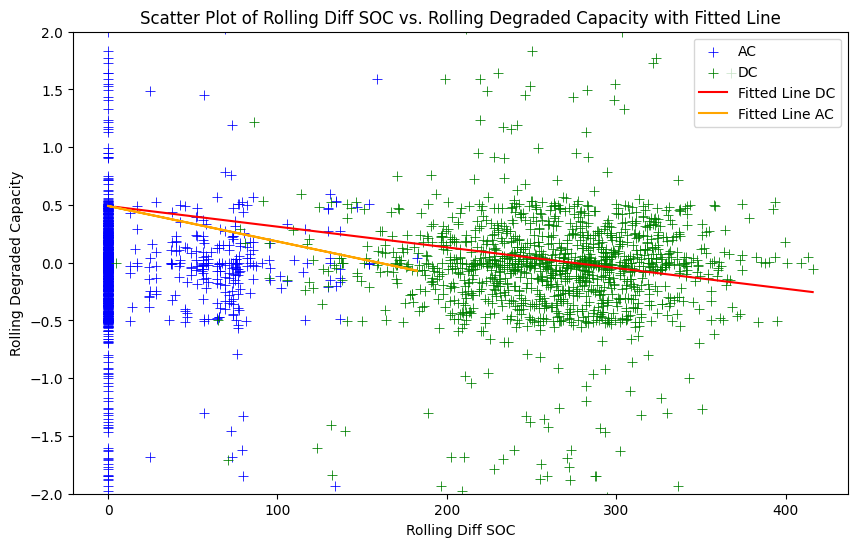

In [50]:

# Extract coefficients
intercept = model.params['Intercept']
coefficient_dc = model.params['rolling_diff_soc_DC']
coefficient_ac = model.params['rolling_diff_soc_AC']

# Create scatter plots
plt.figure(figsize=(10, 6))

# Scatter plot for AC sessions
sns.scatterplot(data=df_sessions, y='rolling_degraded_capacity', x='rolling_diff_soc_AC', color='blue', label='AC', marker="+", s=50)

# Scatter plot for DC sessions
sns.scatterplot(data=df_sessions, y='rolling_degraded_capacity', x='rolling_diff_soc_DC', color='green', label='DC', marker="+", s=50)

# Compute fitted values for plotting the regression line
df_sessions['fitted_values'] = intercept + df_sessions['rolling_diff_soc_DC'] * coefficient_dc + df_sessions['rolling_diff_soc_AC'] * coefficient_ac

# Sort the DataFrame for a smoother line plot
df_sessions = df_sessions.sort_values(by='rolling_diff_soc_DC')

# Plot the fitted regression line for DC
plt.plot(df_sessions['rolling_diff_soc_DC'], intercept + df_sessions['rolling_diff_soc_DC'] * coefficient_dc, color='red', label='Fitted Line DC')

# Plot the fitted regression line for AC
plt.plot(df_sessions['rolling_diff_soc_AC'], intercept + df_sessions['rolling_diff_soc_AC'] * coefficient_ac, color='orange', label='Fitted Line AC')

# Set axis labels and title
plt.ylabel('Rolling Degraded Capacity')
plt.xlabel('Rolling Diff SOC')
plt.title('Scatter Plot of Rolling Diff SOC vs. Rolling Degraded Capacity with Fitted Line')

# Add legend
plt.legend()

plt.ylim([-2,2])

# Show the plot
plt.show()

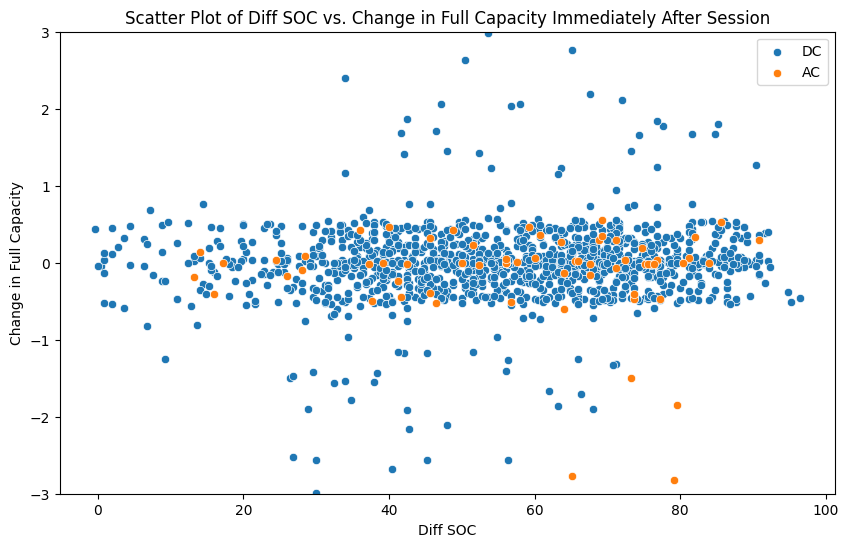

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# df_sessions = df_sessions.loc[:, ~df_sessions.columns.duplicated()]
df_sessions = df_sessions.loc[~df_sessions.index.duplicated()]

# Compute the change in full_capacity since the last row
df_sessions['change_in_full_capacity'] = df_sessions['full_capacity'].diff()

df_sessions = df_sessions.drop_duplicates()

# Create scatter plots
plt.figure(figsize=(10, 6))

# Scatter plot for DC/AC sessions
sns.scatterplot(data=df_sessions[df_sessions['charging_type'] == 'DC'], y='change_in_full_capacity', x='diff_soc', label='DC')
sns.scatterplot(data=df_sessions[df_sessions['charging_type'] == 'AC'], y='change_in_full_capacity', x='diff_soc', label='AC')

# Set axis labels and title
plt.xlabel('Diff SOC')
plt.ylabel('Change in Full Capacity')
plt.title('Scatter Plot of Diff SOC vs. Change in Full Capacity Immediately After Session')

plt.ylim([-3, 3])

# Add legend
plt.legend()

# Show the plot
plt.show()


In [51]:
# Define the formula for the linear regression, including interaction terms
formula = 'rolling_degraded_capacity ~ rolling_diff_soc_DC + rolling_diff_soc_AC'

# Fit the model
model = smf.ols(formula=formula, data=df_sessions).fit()

# Print the model summary
print(model.summary())


                                OLS Regression Results                               
Dep. Variable:     rolling_degraded_capacity   R-squared:                       0.008
Model:                                   OLS   Adj. R-squared:                  0.006
Method:                        Least Squares   F-statistic:                     5.214
Date:                       Mon, 10 Jun 2024   Prob (F-statistic):            0.00555
Time:                               04:54:42   Log-Likelihood:                -2041.3
No. Observations:                       1344   AIC:                             4089.
Df Residuals:                           1341   BIC:                             4104.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

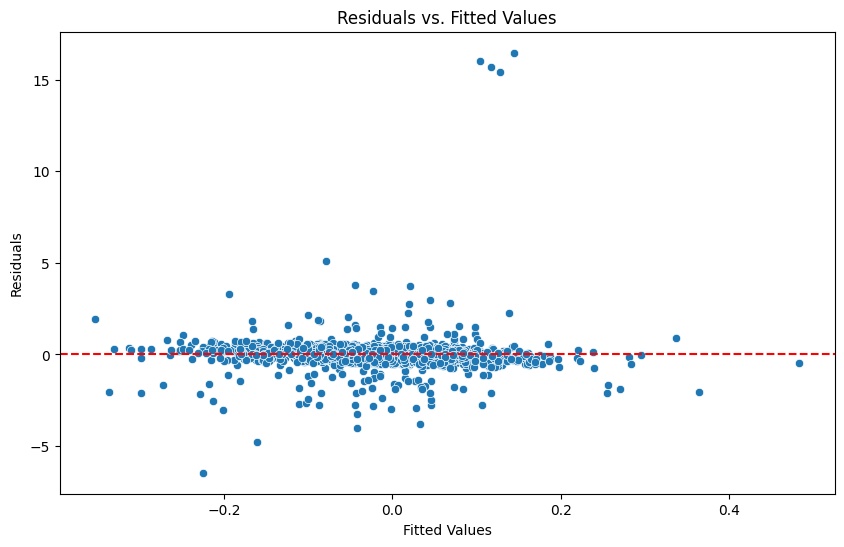

In [44]:
# df_sessions['residuals'] = model.resid

# df_sessions = df_sessions.loc[~df_sessions.index.duplicated()]


# Plot the residuals
plt.figure(figsize=(10, 6))

# Scatter plot of residuals vs. fitted values
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()


## A more complex model with interactive terms 

In [13]:
# Define the formula for the linear regression, including interaction terms
formula = 'rolling_degraded_capacity ~ rolling_diff_soc_DC + rolling_charging_type_DC + rolling_diff_soc_DC:rolling_charging_type_DC + rolling_diff_soc_AC + rolling_charging_type_AC + rolling_diff_soc_AC:rolling_charging_type_AC'

# Fit the model
model = smf.ols(formula=formula, data=df_sessions).fit()

# Print the model summary
print(model.summary())

# Display the formula with the fitted coefficients
intercept = model.params['Intercept']
rolling_diff_soc_DC_coef = model.params['rolling_diff_soc_DC']
rolling_charging_type_DC_coef = model.params['rolling_charging_type_DC']
rolling_diff_soc_DC_interaction_coef = model.params['rolling_diff_soc_DC:rolling_charging_type_DC']
rolling_diff_soc_AC_coef = model.params['rolling_diff_soc_AC']
rolling_charging_type_AC_coef = model.params['rolling_charging_type_AC']
rolling_diff_soc_AC_interaction_coef = model.params['rolling_diff_soc_AC:rolling_charging_type_AC']

formula_fitted = (f"rolling_degraded_capacity = {intercept:.4f} + ({rolling_diff_soc_DC_coef:.4f} * rolling_diff_soc_DC) + "
                  f"({rolling_charging_type_DC_coef:.4f} * rolling_charging_type_DC) + "
                  f"({rolling_diff_soc_DC_interaction_coef:.4f} * rolling_diff_soc_DC * rolling_charging_type_DC) + "
                  f"({rolling_diff_soc_AC_coef:.4f} * rolling_diff_soc_AC) + "
                  f"({rolling_charging_type_AC_coef:.4f} * rolling_charging_type_AC) + "
                  f"({rolling_diff_soc_AC_interaction_coef:.4f} * rolling_diff_soc_AC * rolling_charging_type_AC)")
print("Fitted Linear Regression Formula:", formula_fitted)



                                OLS Regression Results                               
Dep. Variable:     rolling_degraded_capacity   R-squared:                       0.078
Model:                                   OLS   Adj. R-squared:                  0.078
Method:                        Least Squares   F-statistic:                     378.5
Date:                       Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                               03:33:12   Log-Likelihood:                -39839.
No. Observations:                      26880   AIC:                         7.969e+04
Df Residuals:                          26873   BIC:                         7.975e+04
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=119995d2-42f9-4679-a55c-cd52fa6a2421' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>